# 기본 컬럼 생성, 삭제, 이름 변경

In [1]:
import seaborn as sns
import pandas as pd

# Seaborn의 tips 데이터셋을 불러옵니다.
tips = sns.load_dataset('tips')

# ① 새로운 컬럼 생성: 팁 비율 (팁 금액을 총 지불 금액으로 나눈 백분율)
# 벡터화된 연산으로 모든 행에 대해 한 번에 계산합니다.
tips['tip_pct'] = (tips['tip'] / tips['total_bill'] * 100).round(1)

# ② 컬럼 이름 변경: 'sex' 컬럼을 'Gender'로 변경
# inplace=True를 사용해 원본 DataFrame을 바로 수정합니다.
tips.rename(columns={'sex': 'Gender'}, inplace=True)

# ③ 컬럼 삭제: 'size' 컬럼 제거
# inplace=True를 사용해 원본 DataFrame을 바로 수정합니다.
tips.drop(columns=['size'], inplace=True)

print(tips.head(3))

   total_bill   tip  Gender smoker  day    time  tip_pct
0       16.99  1.01  Female     No  Sun  Dinner      5.9
1       10.34  1.66    Male     No  Sun  Dinner     16.1
2       21.01  3.50    Male     No  Sun  Dinner     16.7


# 조건 기반 컬럼 생성 (조건부 값 할당)

In [3]:
import numpy as np
import seaborn as sns

tips = sns.load_dataset('tips')

# tip이 3달러 이상이면 'Large', 아니면 'Small'로 분류하는 컬럼 생성
tips['tip_size'] = np.where(tips['tip'] >= 3.0, 'Large', 'Small')

print(tips[['total_bill', 'tip', 'tip_size']].head(5))

   total_bill   tip tip_size
0       16.99  1.01    Small
1       10.34  1.66    Small
2       21.01  3.50    Large
3       23.68  3.31    Large
4       24.59  3.61    Large


# 타입 변환 및 dtype 최적화 

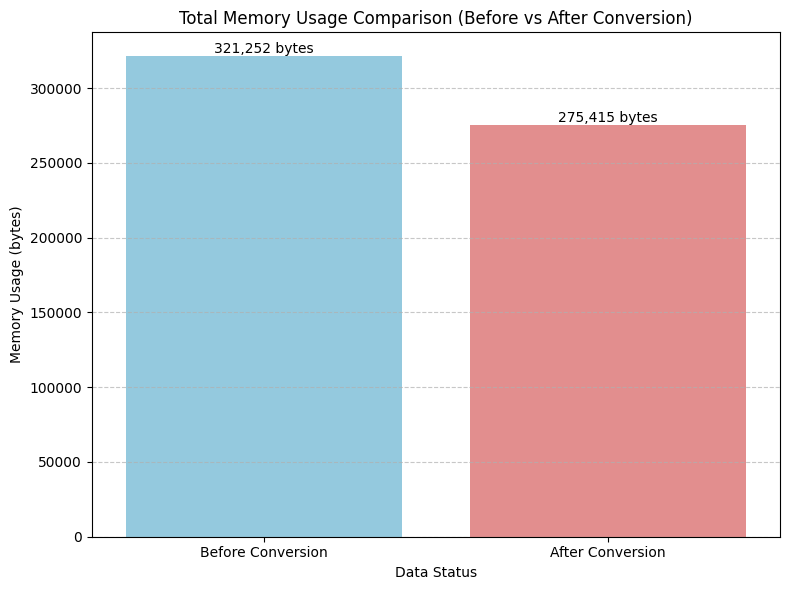

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드
titanic = sns.load_dataset('titanic')

# 2. 변환 전 메모리 사용량
mem_before_total = titanic.memory_usage(deep=True).sum()

# 3. 데이터 타입 변환
titanic['sex'] = titanic['sex'].astype('category')              # 문자열 → category
titanic['age_int'] = titanic['age'].round().astype('Int64')     # 소수 → 반올림 → nullable int

# 4. 변환 후 메모리 사용량
mem_after_total = titanic.memory_usage(deep=True).sum()

# 5. 비교 데이터프레임 생성
memory_data = pd.DataFrame({
    'Status': ['Before Conversion', 'After Conversion'],
    'Total Memory Usage (bytes)': [mem_before_total, mem_after_total]
})

# 6. 시각화
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    x='Status', 
    y='Total Memory Usage (bytes)', 
    hue='Status', 
    data=memory_data, 
    palette=['skyblue', 'lightcoral'], 
    legend=False,
    ax=ax
)

ax.set_title('Total Memory Usage Comparison (Before vs After Conversion)')
ax.set_xlabel('Data Status')
ax.set_ylabel('Memory Usage (bytes)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(bottom=0)

# 값 표시
for i, row in memory_data.iterrows():
    ax.text(i, row['Total Memory Usage (bytes)'], 
            f'{row["Total Memory Usage (bytes)"]:,} bytes',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 실전 응용

In [8]:
import requests
import pandas as pd
from datetime import datetime
import json
import concurrent.futures
import io
import zlib
import os

# API 인증 키 및 기본 URL (매매 API)
API_KEY = "4e506f62416a686a3131355164764c6f"
BASE_URL = f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/tbLnOpendataRtmsV"

def get_apartment_sale_data(year):
    """
    특정 연도의 아파트 매매 데이터를 가져옵니다.
    RCPT_YR 파라미터를 사용하여 연도별 데이터를 필터링합니다.
    """
    start_index = 1
    end_index = 1000  # API 호출 시 한번에 가져올 수 있는 최대 데이터 수를 늘림
    url = f"{BASE_URL}/{start_index}/{end_index}/{year}"

    try:
        print(f"DEBUG: {year}년도 API 요청 시작...")
        response = requests.get(url, timeout=30)
        response.raise_for_status()

        if not response.text:
            print(f"{year}년도 API 응답이 비어있습니다.")
            return None

        data = response.json()

        if 'tbLnOpendataRtmsV' in data and 'row' in data['tbLnOpendataRtmsV']:
            sale_list = data['tbLnOpendataRtmsV']['row']
            # 아파트 데이터만 필터링
            apartment_data = [item for item in sale_list if "아파트" in item.get('BLDG_USG', '')]
            return apartment_data
        else:
            return None

    except requests.exceptions.RequestException as e:
        print(f"API 요청 중 오류 발생 (연도: {year}): {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"JSON 파싱 오류 (연도: {year}): {e}")
        return None
    except Exception as e:
        print(f"알 수 없는 오류 발생 (연도: {year}): {e}")
        return None

def process_data(data_list):
    """
    데이터 리스트를 받아 DataFrame으로 변환하고, 데이터 변환 및 파생변수를 생성합니다.
    """
    if not data_list:
        return None

    # 1. DataFrame 생성
    df = pd.DataFrame(data_list)
    initial_memory_usage = df.memory_usage(deep=True).sum()
    print(f"변환 전 메모리 사용량: {initial_memory_usage / 1024 / 1024:.2f} MB")

    # 2. 데이터 타입 변환 및 메모리 최적화
    # 숫자형 컬럼 변환
    for col in ['RCPT_YR', 'THING_AMT', 'ARCH_AREA', 'LAND_AREA', 'FLR', 'ARCH_YR']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int32')

    # 날짜형 컬럼 변환
    if 'CTRT_DAY' in df.columns:
        df['CTRT_DT'] = pd.to_datetime(df['CTRT_DAY'], format='%Y%m%d', errors='coerce')
        df = df.drop('CTRT_DAY', axis=1) # 원본 컬럼 삭제

    # 카테고리형(문자열) 컬럼 변환
    for col in ['CGG_NM', 'STDG_NM', 'BLDG_NM', 'BLDG_USG', 'OPBIZ_RESTAGNT_SGG_NM']:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 3. 유의미한 파생변수 생성
    # '거래_연월' 파생변수 생성 (YYYY-MM 형식)
    if 'CTRT_DT' in df.columns:
        df['TRAD_YRMTH'] = df['CTRT_DT'].dt.to_period('M')

    # '평당_가격' 파생변수 생성 (THING_AMT / ARCH_AREA)
    if 'THING_AMT' in df.columns and 'ARCH_AREA' in df.columns:
        # 0으로 나누는 경우를 방지
        df['SQM_PRICE'] = df.apply(
            lambda row: row['THING_AMT'] / row['ARCH_AREA'] if row['ARCH_AREA'] > 0 else 0,
            axis=1
        )
        df['SQM_PRICE'] = df['SQM_PRICE'].astype('float32') # 메모리 최적화

    final_memory_usage = df.memory_usage(deep=True).sum()
    print(f"변환 후 메모리 사용량: {final_memory_usage / 1024 / 1024:.2f} MB")
    print(f"메모리 사용량 최적화 비율: {(1 - final_memory_usage / initial_memory_usage) * 100:.2f}% 감소")

    return df

def save_and_compare_file_sizes(df, base_filename='apartment_sales_data'):
    """
    DataFrame을 일반 CSV와 압축된 CSV로 저장하고 파일 크기를 비교합니다.
    """
    if df is None:
        print("저장할 데이터가 없습니다.")
        return

    # 1. 일반 CSV로 저장
    csv_filename = f'{base_filename}.csv'
    df.to_csv(csv_filename, index=False)
    csv_size = os.path.getsize(csv_filename)
    print(f"일반 CSV 파일 '{csv_filename}' 저장 완료. 크기: {csv_size / 1024:.2f} KB")

    # 2. 압축된 CSV로 저장
    compressed_filename = f'{base_filename}.csv.gz'
    df.to_csv(compressed_filename, index=False, compression='gzip')
    compressed_size = os.path.getsize(compressed_filename)
    print(f"압축된 CSV 파일 '{compressed_filename}' 저장 완료. 크기: {compressed_size / 1024:.2f} KB")

    # 3. 크기 비교 및 결과 출력
    if csv_size > 0:
        compression_ratio = (1 - compressed_size / csv_size) * 100
        print(f"\n✨ 파일 압축률: 일반 CSV 대비 약 {compression_ratio:.2f}% 감소!")
    else:
        print("파일 크기 비교를 위한 일반 CSV 파일 크기가 0입니다.")


if __name__ == "__main__":
    years_to_fetch = [2023, 2024]
    
    print(f"### 부동산 매매 데이터 수집 및 처리 시작 (연도: {years_to_fetch}) ###")
    
    combined_data = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=len(years_to_fetch)) as executor:
        future_to_year = {executor.submit(get_apartment_sale_data, year): year for year in years_to_fetch}
        
        for future in concurrent.futures.as_completed(future_to_year):
            year = future_to_year[future]
            try:
                data_list = future.result()
                if data_list:
                    combined_data.extend(data_list)
                    print(f"✅ {year}년도 데이터 {len(data_list)}개 수집 완료.")
                else:
                    print(f"⚠️ {year}년도 데이터 수집 실패 또는 데이터 없음.")
            except Exception as exc:
                print(f"❌ {year}년도 데이터 처리 중 예외 발생: {exc}")
    
    if combined_data:
        print(f"\n총 {len(combined_data)}개의 데이터로 DataFrame 생성 시작.")
        df_result = process_data(combined_data)
        
        if df_result is not None:
            print("\n### 데이터 저장 및 파일 크기 비교 ###")
            save_and_compare_file_sizes(df_result)
    else:
        print("\n데이터를 수집하지 못해 작업을 종료합니다.")
        
    print("\n### 모든 작업이 완료되었습니다. ###")

### 부동산 매매 데이터 수집 및 처리 시작 (연도: [2023, 2024]) ###
DEBUG: 2023년도 API 요청 시작...
DEBUG: 2024년도 API 요청 시작...
✅ 2023년도 데이터 368개 수집 완료.
✅ 2024년도 데이터 449개 수집 완료.

총 817개의 데이터로 DataFrame 생성 시작.
변환 전 메모리 사용량: 1.03 MB
변환 후 메모리 사용량: 0.61 MB
메모리 사용량 최적화 비율: 40.40% 감소

### 데이터 저장 및 파일 크기 비교 ###
일반 CSV 파일 'apartment_sales_data.csv' 저장 완료. 크기: 130.76 KB
압축된 CSV 파일 'apartment_sales_data.csv.gz' 저장 완료. 크기: 23.53 KB

✨ 파일 압축률: 일반 CSV 대비 약 82.01% 감소!

### 모든 작업이 완료되었습니다. ###


## 데이터 가져와서 확인

In [9]:
import pandas as pd

# CSV.GZ 파일 읽기
df1 = pd.read_csv("apartment_sales_data.csv.gz")

# 데이터 확인
df1.head()

,RCPT_YR,CGG_CD,CGG_NM,STDG_CD,STDG_NM,LOTNO_SE,LOTNO_SE_NM,MNO,SNO,BLDG_NM,...,FLR,RGHT_SE,RTRCN_DAY,ARCH_YR,BLDG_USG,DCLR_SE,OPBIZ_RESTAGNT_SGG_NM,CTRT_DT,TRAD_YRMTH,SQM_PRICE
0,2023,11290,성북구,13600,하월곡동,1,대지,225,0,래미안월곡,...,2,NaN,NaN,2006,아파트,중개거래,서울 성북구,2023-12-31,2023-12,1161.01700
1,2023,11440,마포구,12600,중동,1,대지,40,12,현대,...,1,NaN,NaN,2000,아파트,중개거래,서울 마포구,2023-12-30,2023-12,983.05084
2,2023,11560,영등포구,11000,여의도동,1,대지,47,0,여의도자이,...,21,NaN,NaN,2008,아파트,중개거래,서울 영등포구,2023-12-29,2023-12,1866.66660
3,2023,11305,강북구,10100,미아동,1,대지,705,1,한화 포레나 미아,...,6,분양권,20240906.0,0,아파트,중개거래,서울 강북구,2023-12-29,2023-12,1356.79760
4,2023,11545,금천구,10200,독산동,1,대지,1093,4,한신아파트,...,5,NaN,NaN,1991,아파트,중개거래,서울 금천구,2023-12-29,2023-12,671.91010


In [10]:
import pandas as pd

# CSV.GZ 파일 읽기
df2 = pd.read_csv("apartment_sales_data.csv")

# 데이터 확인
df2.head()

,RCPT_YR,CGG_CD,CGG_NM,STDG_CD,STDG_NM,LOTNO_SE,LOTNO_SE_NM,MNO,SNO,BLDG_NM,...,FLR,RGHT_SE,RTRCN_DAY,ARCH_YR,BLDG_USG,DCLR_SE,OPBIZ_RESTAGNT_SGG_NM,CTRT_DT,TRAD_YRMTH,SQM_PRICE
0,2023,11290,성북구,13600,하월곡동,1,대지,225,0,래미안월곡,...,2,NaN,NaN,2006,아파트,중개거래,서울 성북구,2023-12-31,2023-12,1161.01700
1,2023,11440,마포구,12600,중동,1,대지,40,12,현대,...,1,NaN,NaN,2000,아파트,중개거래,서울 마포구,2023-12-30,2023-12,983.05084
2,2023,11560,영등포구,11000,여의도동,1,대지,47,0,여의도자이,...,21,NaN,NaN,2008,아파트,중개거래,서울 영등포구,2023-12-29,2023-12,1866.66660
3,2023,11305,강북구,10100,미아동,1,대지,705,1,한화 포레나 미아,...,6,분양권,20240906.0,0,아파트,중개거래,서울 강북구,2023-12-29,2023-12,1356.79760
4,2023,11545,금천구,10200,독산동,1,대지,1093,4,한신아파트,...,5,NaN,NaN,1991,아파트,중개거래,서울 금천구,2023-12-29,2023-12,671.91010
